In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold

from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

## Считываем данные и разбиваем их на тренировочную и тестовую выборки

In [2]:
with open('data/data_for_models.csv') as f:
    data = pd.read_csv(f)

In [3]:
numeric_cols = data.select_dtypes(include='number').columns.tolist() # оставляю только числовые столбцы

data = data.astype({
    col: 'int64' for col in numeric_cols 
})

In [4]:
random_state = 2025 # нужен для повторяемости результатов

pos_data = data.query("target == 1")

# оставляем только 33% случайных сэмплов класса 0 для каждого диска
neg_data = (
    data
    .query("target == 0")
    .groupby("serial_number", as_index=False)
    .apply(lambda x: x.sample(frac=0.33, random_state=random_state))
    .reset_index(drop=True)
)

# новый датасет
data = pd.concat((neg_data, pos_data), axis=0)

In [5]:
data = data.drop(columns = ['serial_number', 'date'])

In [7]:
data.head()

,smart_5_last,smart_9_last,smart_187_last,smart_188_last,smart_192_last,smart_198_last,smart_199_last,smart_240_last,smart_241_last,smart_242_last,block,smart_5_diff,smart_187_diff,smart_198_diff,smart_199_max,smart_5_auc,smart_187_auc,smart_198_auc,target
0,0,16507,0,0,3,0,0,15948,98121318264,234810359494,23,0,0,0,0,0,0,0,0
1,0,13631,0,0,3,0,0,13097,88405181240,194441877008,19,0,0,0,0,0,0,0,0
2,0,6429,0,0,3,0,0,5939,62977305968,106747494514,9,0,0,0,0,0,0,0,0
3,0,3553,0,0,0,0,0,3110,43138957032,69458441764,5,0,0,0,0,0,0,0,0
4,0,7147,0,0,3,0,0,6653,66249905800,115393592954,10,0,0,0,0,0,0,0,0


In [8]:
# Т.к. нам нужно, чтобы в тестовой выборки с реальными данными не осталось 2-3 экземпляра класса 1 - проведём следующее разделение

# Разделяем данные класса 1 и класса 0
class_1 = data[data['target'] == 1]
class_0 = data[data['target'] == 0]

# Фиксируем 17% объектов класса 1 для тестовой выборки (можно попробовать взять меньше - больше)
class_1_train, class_1_test = train_test_split(class_1, test_size=0.17, random_state=random_state)

# Добавляем пропорциональное количество данных класса 0
class_0_train, class_0_test = train_test_split(class_0, test_size=0.17, random_state=random_state)

# Собираем тренировочные и тестовые выборки
train_data = pd.concat([class_1_train, class_0_train])
test_data = pd.concat([class_1_test, class_0_test])

# Перемешиваем данные
train_data = train_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=random_state).reset_index(drop=True)

# Разделяем на X и y для обучения и теста
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

In [9]:
data.head()

,smart_5_last,smart_9_last,smart_187_last,smart_188_last,smart_192_last,smart_198_last,smart_199_last,smart_240_last,smart_241_last,smart_242_last,block,smart_5_diff,smart_187_diff,smart_198_diff,smart_199_max,smart_5_auc,smart_187_auc,smart_198_auc,target
0,0,16507,0,0,3,0,0,15948,98121318264,234810359494,23,0,0,0,0,0,0,0,0
1,0,13631,0,0,3,0,0,13097,88405181240,194441877008,19,0,0,0,0,0,0,0,0
2,0,6429,0,0,3,0,0,5939,62977305968,106747494514,9,0,0,0,0,0,0,0,0
3,0,3553,0,0,0,0,0,3110,43138957032,69458441764,5,0,0,0,0,0,0,0,0
4,0,7147,0,0,3,0,0,6653,66249905800,115393592954,10,0,0,0,0,0,0,0,0


## Отдельное обучение одной модели

### Перебор параметров

Помогло [это обсуждение](https://stackoverflow.com/questions/58815016/cross-validating-with-imblearn-pipeline-and-gridsearchcv) на stackoverflow

In [10]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

Перебор параметров модели при обучении на всех признаках занимает много времени, поэтому найдём лучшие параметры на пяти признаках ниже, а затем обучим модель с этими параметрами на всех признаках

Признаки выбраны как минимально коррелирующие друг с другом (см. Feature Importance ниже)

In [11]:
final_features = [
    'smart_5_last', 
    'smart_9_last', 
    'smart_187_last',
    'smart_188_last',
    'smart_198_auc'
]

In [12]:
# Определение модели и кросс-валидации
clf = RandomForestClassifier(random_state=random_state)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Использую специальный класс Pipeline из imblearn
# Он применяет преобразования только к тренировочному датасету
pipe = Pipeline([
    ('transform', SMOTEENN(random_state=random_state)),
    ('classify', clf)
])

# Метрики, по которым будем оценивать модель
score = {
    'ROC-AUC': 'roc_auc', 
    'Recall': 'recall',
    'Precision': 'precision',
    'F1-Score': 'f1'
}

# Значение параметра выбирается равновероятно из списка
params = {
    'classify__n_estimators': [100, 150],
    'classify__max_depth': [50, None],
    'classify__max_features': ['sqrt', 'log2'],
    'classify__criterion': ['gini', 'entropy', 'log_loss']
}

# Всего 10 комбинаций параметров будет проверено
rscv = RandomizedSearchCV(
    pipe,
    params,
    n_iter=10,
    cv=cv,
    scoring=score,
    n_jobs=4,
    refit='ROC-AUC',
    return_train_score=True
)

rscv.fit(X_train[final_features], y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2025, shuffle=True),
                   estimator=Pipeline(steps=[('transform',
                                              SMOTEENN(random_state=2025)),
                                             ('classify',
                                              RandomForestClassifier(random_state=2025))]),
                   n_jobs=4,
                   param_distributions={'classify__criterion': ['gini',
                                                                'entropy',
                                                                'log_loss'],
                                        'classify__max_depth': [50, None],
                                        'classify__max_features': ['sqrt',
                                                                   'log2'],
                                        'classify__n_estimators': [100, 150]},
                   refit='ROC-AUC', return_train_score=True,
                   scoring={'F1-Score': 'f1', 'Precision': 'precision',
                            'ROC-AUC': 'roc_auc', 'Recall': 'recall'})

In [13]:
best_params = {key[10:]: value for key, value in rscv.best_params_.items()}
best_params['random_state'] = random_state
best_params

{'n_estimators': 150,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'entropy',
 'random_state': 2025}

In [14]:
rscv.best_score_

0.8953093583710879

Снова обучим модель, но уже на всех признаках

In [16]:
# Определение модели и кросс-валидации
clf = RandomForestClassifier(**best_params, n_jobs=4)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Заводим массив для метрик кросс-валидации
roc_auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Кросс-валидация с балансировкой данных с помощью SMOTEENN
for train_idx, val_idx in tqdm(cv.split(X_train, y_train), total=cv.get_n_splits(), desc="Cross-validation"):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    smote_enn = SMOTEENN(random_state=random_state, n_jobs=4)
    X_resampled, y_resampled = smote_enn.fit_resample(X_fold_train, y_fold_train)
    
    # Обучение модели на синтетических данных
    clf.fit(X_resampled, y_resampled)
    
    # Оценка на валидационной выборке (реальные данные)
    y_val_pred = clf.predict(X_fold_val)
    y_val_pred_proba = clf.predict_proba(X_fold_val)[:, 1]
    
    # Расчёт метрик
    roc_auc = roc_auc_score(y_fold_val, y_val_pred_proba)
    precision = precision_score(y_fold_val, y_val_pred)
    recall = recall_score(y_fold_val, y_val_pred)
    f1 = f1_score(y_fold_val, y_val_pred)
    
    roc_auc_scores.append(roc_auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Вывод метрик кросс-валидации
print(f"Средний ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")
print(f"Средний Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
print(f"Средний Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
print(f"Средний F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

Cross-validation: 100%|██████████████████████████| 5/5 [30:04<00:00, 360.99s/it]

Средний ROC-AUC: 0.9458 ± 0.0262
Средний Precision: 0.2018 ± 0.0311
Средний Recall: 0.3881 ± 0.0840
Средний F1-Score: 0.2644 ± 0.0424


In [18]:
# Финальное тестирование на реальных данных
smote_enn = SMOTEENN(random_state=random_state, n_jobs=4)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

clf.fit(X_resampled, y_resampled)

y_test_pred = clf.predict(X_test)
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

print("\nКлассификационный отчет на тестовых данных (реальные данные):")
print(classification_report(y_test, y_test_pred, digits=4))

print(f"ROC-AUC на тестовых данных: {roc_auc_score(y_test, y_test_pred_proba):.4f}")
print(f"Precision на тестовых данных: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall на тестовых данных: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score на тестовых данных: {f1_score(y_test, y_test_pred):.4f}")


Классификационный отчет на тестовых данных (реальные данные):
              precision    recall  f1-score   support

           0     0.9989    0.9963    0.9976     13534
           1     0.2188    0.4828    0.3011        29

    accuracy                         0.9952     13563
   macro avg     0.6088    0.7395    0.6493     13563
weighted avg     0.9972    0.9952    0.9961     13563

ROC-AUC на тестовых данных: 0.9733
Precision на тестовых данных: 0.2188
Recall на тестовых данных: 0.4828
F1-Score на тестовых данных: 0.3011


Использование классификатора на основе деревьев позволяет посмотреть, какие признаки внесли наибольший вклад, и затем убрать ненужные

### Важность признаков Джини (Gini importance)

Вычисляется как (нормализованное) общее снижение критерия, вызванного этим признаком

Чем больше значение, тем важнее признак

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [20]:
importances = pd.DataFrame({
    'feature': clf.feature_names_in_.tolist(),
    'importance': clf.feature_importances_
})

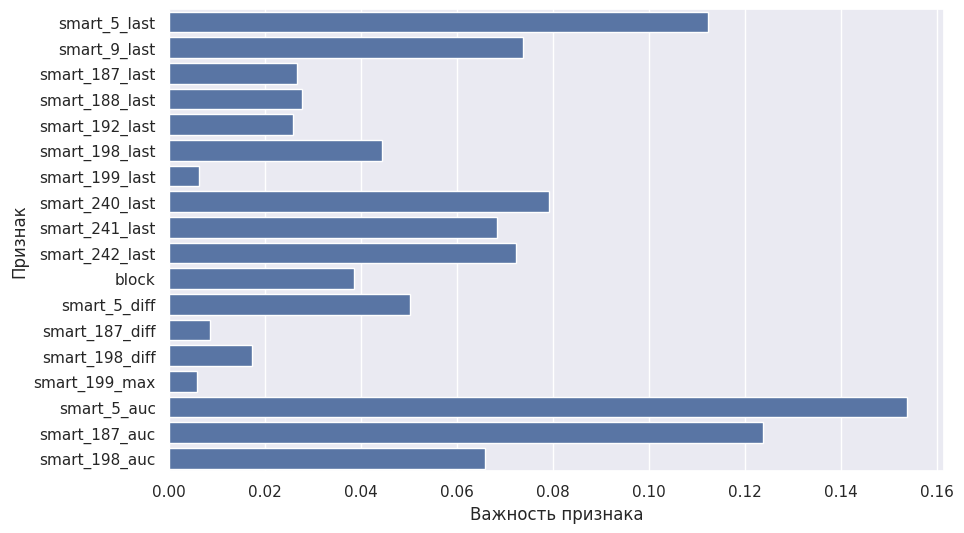

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(importances, y='feature', x='importance', orient='h')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.show()

Наиболее важными оказались признаки smart_5_auc, smart_5_last, smart_187_auc, smart_240_last, smart_198_auc

Однако при большом числе возможных значений признака такой подход к интерпретации важности может запутывать, поэтому посмотрим также с помощью Feature Permutation

### Feature Permutation

In [22]:
from sklearn.inspection import permutation_importance

In [23]:
result = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=random_state,
    n_jobs=2
)

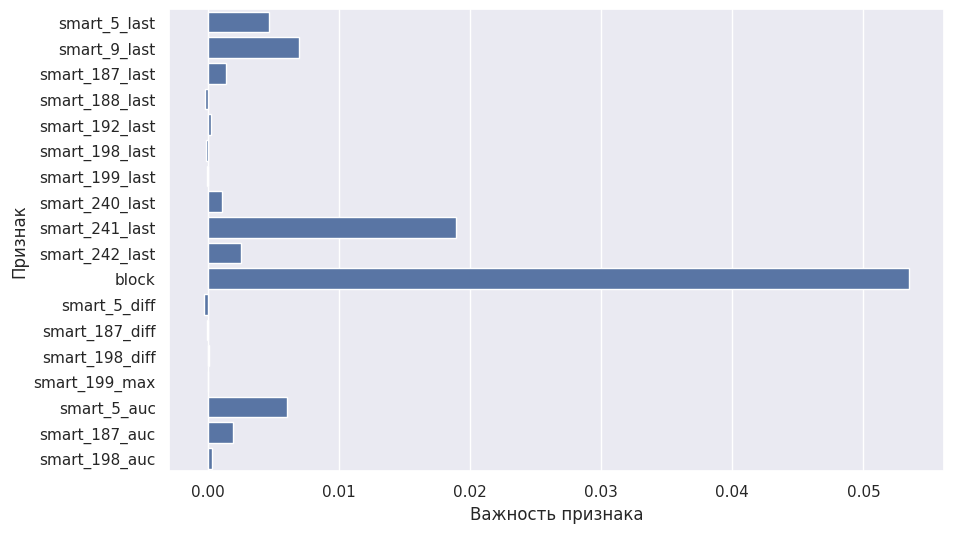

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x=result['importances_mean'], y=importances['feature'], orient='h')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.show()

Кажется, что все признаки не важны, несмотря на высокое качество классификации, но это происходит из-за того, что среди них есть сильно скоррелированные

Сильная корреляция, в свою очередь, приводит к уменьшению важности каждого из таких признаков (см. подробнее [здесь](https://scikit-learn.org/1.5/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py))

### Отбор признаков

Выполним иерархическую кластеризацию признаков и выберем по одному признаку из кластера

Кластеризовать будем алгоритмом Ward's linkage на основе матрицы расстояний, вычисленной через матрицу корреляции признаков по Спирману

Это должно обеспечить сопоставимое качество при меньшем числе признаков (и отсутствии значимой корреляции между ними)

In [25]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

from collections import defaultdict

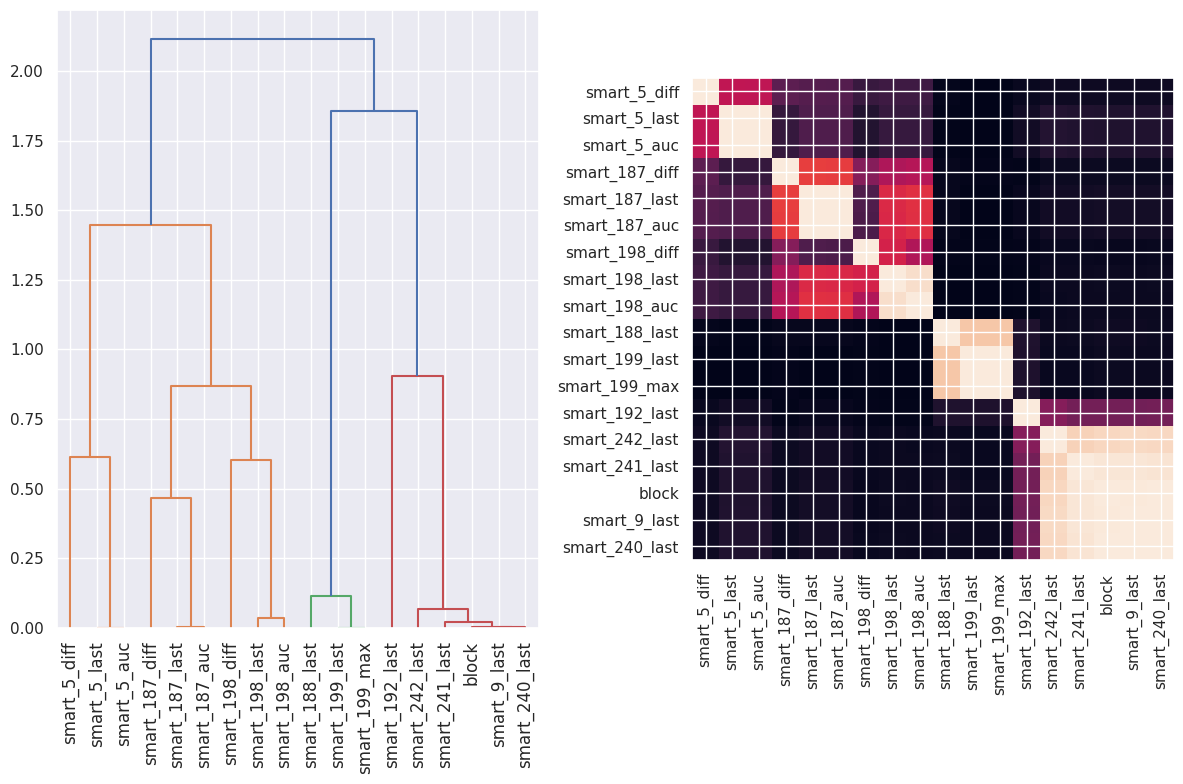

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Считаем коэффициент корреляции Спирмана 
# для каждой пары признаков
corr = spearmanr(X_train).correlation

# Делаем симметричную матрицу корреляции
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Преобразуем матрицу корреляций в матрицу расстояний,
# делаем иерархическую кластеризацию с помощью Ward's linkage
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

# Отображаем процесс объединения кластеров на дендрограмме
dendro = hierarchy.dendrogram(
    dist_linkage,
    labels=X_train.columns.to_list(),
    ax=ax1,
    leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [27]:
# Формируем кластеры по linkage матрице
cluster_ids = hierarchy.fcluster(
    dist_linkage,
    1,
    criterion="distance"
)
cluster_id_to_feature_ids = defaultdict(list)

# Собираем индексы признаков каждого кластера в список
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

# Выбираем по одному признаку из кластера
final_features_ids = [v[0] for v in cluster_id_to_feature_ids.values()]
final_features = X_train.columns[final_features_ids].tolist()

In [28]:
final_features

['smart_5_last', 'smart_9_last', 'smart_187_last', 'smart_188_last']

Далее можно обучать классификатор только на этих признаках

## Обучение сразу нескольких моделей

Применим такой же подход к другим моделям и сравним несколько наиболее популярных

### Перебор параметров

In [42]:
# Определение моделей
models = {
    # "Logistic Regression": LogisticRegression(random_state=random_state, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=random_state, n_jobs=4),
    "Extra Trees": ExtraTreesClassifier(random_state=random_state, n_jobs=4),
    "LightGBM": LGBMClassifier(random_state=random_state, num_threads=4),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=random_state),
    "XGBoost": XGBClassifier(eval_metric='auc', random_state=random_state, n_jobs=4, objective='binary:logistic')
}

# Определение кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

In [58]:
# Значение параметра выбирается равновероятно из списка
params = {
    'classify__n_estimators': [50, 100, 150],
    'classify__max_depth': [50, None],
    'classify__max_features': ['sqrt', 'log2', None],
    'classify__max_leaf_nodes': [None, 100],
    'classify__min_samples_leaf': [1, 100, 500],
    'classify__criterion': ['gini', 'entropy', 'log_loss'],
    'classify__warm_start': [False, True]
}

lightgbm_params = {
    'classify__num_leaves': [31, 100, 1000],
    'classify__min_data_in_leaf': [1, 20, 100],
    'classify__max_depth': [50, -1],
    'classify__early_stopping_round': [0, 5],
    'classify__feature_fraction': [1, 0.5]
}

catboost_params = {
    'classify__iterations': [100, 500, 1000],
    'classify__max_leaves': [None, 100, 1000],
    'classify__depth': [50, None],
    'classify__early_stopping_rounds': [None, 5],
    'classify__min_data_in_leaf': [1, 20, 100]
}

xgboost_params = {
    'classify__max_leaves': [0, 100, 1000],
    'classify__subsample': [0.6, 1],
    'classify__tree_method': ['auto', 'hist']
}

params_dict = {
    'Random Forest': params,
    'Extra Trees': params,
    'LightGBM': lightgbm_params,
    'CatBoost': catboost_params,
    'XGBoost': xgboost_params
}

# Метрики, по которым будем оценивать модели
score = {
    'ROC-AUC': 'roc_auc', 
    'Recall': 'recall',
    'Precision': 'precision',
    'F1-Score': 'f1'
}

In [ ]:
best_params_dict = dict()

In [ ]:
# Обучение для каждой модели
for model_name, model in models.items(): 
    print(f"\nОбучение модели: {model_name}")
    
    # Использую специальный класс Pipeline из imblearn
    # Он применяет преобразования только к тренировочному датасету
    pipe = Pipeline([
        ('transform', SMOTEENN(random_state=random_state)),
        ('classify', model)
    ])
    
    # Всего 10 комбинаций параметров будет проверено
    rscv = RandomizedSearchCV(
        pipe,
        params_dict[model_name],
        n_iter=10,
        cv=cv,
        scoring=score,
        n_jobs=4,
        refit='ROC-AUC',
        return_train_score=True
    )
    
    rscv.fit(X_train[final_features], y_train)

    best_params = {key[10:]: value for key, value in rscv.best_params_.items()}
    best_params['random_state'] = random_state
    best_params_dict[model_name] = dict()
    best_params_dict[model_name]['best_params'] = best_params

In [76]:
best_params_dict

{'Random Forest': {'best_params': {'warm_start': True,
   'n_estimators': 100,
   'min_samples_leaf': 100,
   'max_leaf_nodes': None,
   'max_features': None,
   'max_depth': 50,
   'criterion': 'gini',
   'random_state': 2025}},
 'Extra Trees': {'best_params': {'warm_start': False,
   'n_estimators': 150,
   'min_samples_leaf': 1,
   'max_leaf_nodes': None,
   'max_features': None,
   'max_depth': 50,
   'criterion': 'log_loss',
   'random_state': 2025}},
 'LightGBM': {'best_params': {'num_leaves': 1000,
   'min_data_in_leaf': 100,
   'max_depth': 50,
   'feature_fraction': 0.5,
   'early_stopping_round': 0,
   'random_state': 2025}},
 'CatBoost': {'best_params': {'min_data_in_leaf': 20,
   'max_leaves': None,
   'iterations': 100,
   'early_stopping_rounds': 5,
   'depth': None,
   'random_state': 2025}},
 'XGBoost': {'best_params': {'tree_method': 'auto',
   'subsample': 0.6,
   'max_leaves': 1000,
   'random_state': 2025}}}

### Обучение на лучших параметрах

In [79]:
# Массив для хранения результатов метрик по каждой моделей
results = []

# Обучение для каждой модели
for model_name, model in models.items():
    print(f"\nОбучение модели: {model_name}")

    # if model_name != 'CatBoost':
    #     continue
        
    roc_auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Кросс-валидация с балансировкой данных с помощью SMOTEENN
    for train_idx, val_idx in tqdm(cv.split(X_train, y_train), total=cv.get_n_splits(), desc=f"{model_name} CV"):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        smote_enn = SMOTEENN(random_state=random_state, n_jobs=4)
        X_resampled, y_resampled = smote_enn.fit_resample(X_fold_train, y_fold_train)

        # Подгружаем параметры, подобранные выше
        params = best_params_dict[model_name]['best_params']

        # Для CatBoost нужно инициализировать модель со всеми
        # параметрами один раз, иначе вылезает ошибка 
        # "CatBoostError: You can't change params of fitted model."
        if model_name == 'CatBoost':
            model = CatBoostClassifier(verbose=0, **params)
        else:
            model.set_params(**params)

        # Обучение модели на синтетических данных
        model.fit(X_resampled, y_resampled)

        # Оценка на валидационной выборке (реальные данные)
        y_val_pred = model.predict(X_fold_val)
        y_val_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        roc_auc = roc_auc_score(y_fold_val, y_val_pred_proba)
        precision = precision_score(y_fold_val, y_val_pred)
        recall = recall_score(y_fold_val, y_val_pred)
        f1 = f1_score(y_fold_val, y_val_pred)

        roc_auc_scores.append(roc_auc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Сохранение средних значений метрик
    results.append({
        "Model": model_name,
        "ROC-AUC (CV)": f"{np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}",
        "Precision (CV)": f"{np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}",
        "Recall (CV)": f"{np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}",
        "F1-Score (CV)": f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}"
    })

    # Финальное тестирование на реальных данных
    smote_enn = SMOTEENN(random_state=random_state, n_jobs=4)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
    model.fit(X_resampled, y_resampled)

    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    test_metrics = {
        "ROC-AUC (Test)": roc_auc_score(y_test, y_test_pred_proba),
        "Precision (Test)": precision_score(y_test, y_test_pred),
        "Recall (Test)": recall_score(y_test, y_test_pred),
        "F1-Score (Test)": f1_score(y_test, y_test_pred)
    }

    # Добавление тестовых метрик в финальные результаты
    results[-1].update({key: f"{value:.4f}" for key, value in test_metrics.items()})

# Вывод таблицы результатов
results_df = pd.DataFrame(results)

print("\nРезультаты моделей:")
results_df


Обучение модели: Random Forest

Обучение модели: Extra Trees

Обучение модели: LightGBM

Обучение модели: CatBoost


CatBoost CV: 100%|███████████████████████████████| 5/5 [25:57<00:00, 311.52s/it]



Обучение модели: XGBoost

Результаты моделей:


,Model,ROC-AUC (CV),Precision (CV),Recall (CV),F1-Score (CV),ROC-AUC (Test),Precision (Test),Recall (Test),F1-Score (Test)
0,Random Forest,0.9605 ± 0.0324,0.0592 ± 0.0082,0.7635 ± 0.1111,0.1099 ± 0.0153,0.9379,0.0545,0.7241,0.1014
1,Extra Trees,0.9643 ± 0.0199,0.2293 ± 0.0538,0.4611 ± 0.1273,0.3057 ± 0.0749,0.9925,0.2857,0.5517,0.3765
2,LightGBM,0.9301 ± 0.0237,0.1914 ± 0.0550,0.4026 ± 0.1258,0.2583 ± 0.0734,0.9615,0.2500,0.5172,0.3371
3,XGBoost,0.8667 ± 0.0438,0.1585 ± 0.0385,0.4386 ± 0.1237,0.2320 ± 0.0570,0.9467,0.2206,0.5172,0.3093
4,CatBoost,0.8494 ± 0.0683,0.1078 ± 0.0209,0.5397 ± 0.1176,0.1793 ± 0.0341,0.9489,0.1417,0.6207,0.2308


В models после выполнения шага выше хранятся уже обученные модели, их можно исследовать, не обучая повторно

In [80]:
results

[{'Model': 'Random Forest',
  'ROC-AUC (CV)': '0.9605 ± 0.0324',
  'Precision (CV)': '0.0592 ± 0.0082',
  'Recall (CV)': '0.7635 ± 0.1111',
  'F1-Score (CV)': '0.1099 ± 0.0153',
  'ROC-AUC (Test)': '0.9379',
  'Precision (Test)': '0.0545',
  'Recall (Test)': '0.7241',
  'F1-Score (Test)': '0.1014'},
 {'Model': 'Extra Trees',
  'ROC-AUC (CV)': '0.9643 ± 0.0199',
  'Precision (CV)': '0.2293 ± 0.0538',
  'Recall (CV)': '0.4611 ± 0.1273',
  'F1-Score (CV)': '0.3057 ± 0.0749',
  'ROC-AUC (Test)': '0.9925',
  'Precision (Test)': '0.2857',
  'Recall (Test)': '0.5517',
  'F1-Score (Test)': '0.3765'},
 {'Model': 'LightGBM',
  'ROC-AUC (CV)': '0.9301 ± 0.0237',
  'Precision (CV)': '0.1914 ± 0.0550',
  'Recall (CV)': '0.4026 ± 0.1258',
  'F1-Score (CV)': '0.2583 ± 0.0734',
  'ROC-AUC (Test)': '0.9615',
  'Precision (Test)': '0.2500',
  'Recall (Test)': '0.5172',
  'F1-Score (Test)': '0.3371'},
 {'Model': 'XGBoost',
  'ROC-AUC (CV)': '0.8667 ± 0.0438',
  'Precision (CV)': '0.1585 ± 0.0385',
  'Rec

In [81]:
results_df.to_csv("results/models_results_resampled.csv", index=False)

Лучшую модель выбираем по совокупности метрик, здесь это Extra Trees

In [247]:
best_model = models['Extra Trees']

Визуализируем ROC-/PR-кривые и Confusion Matrix

In [248]:
from sklearn.metrics import (
    RocCurveDisplay, 
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

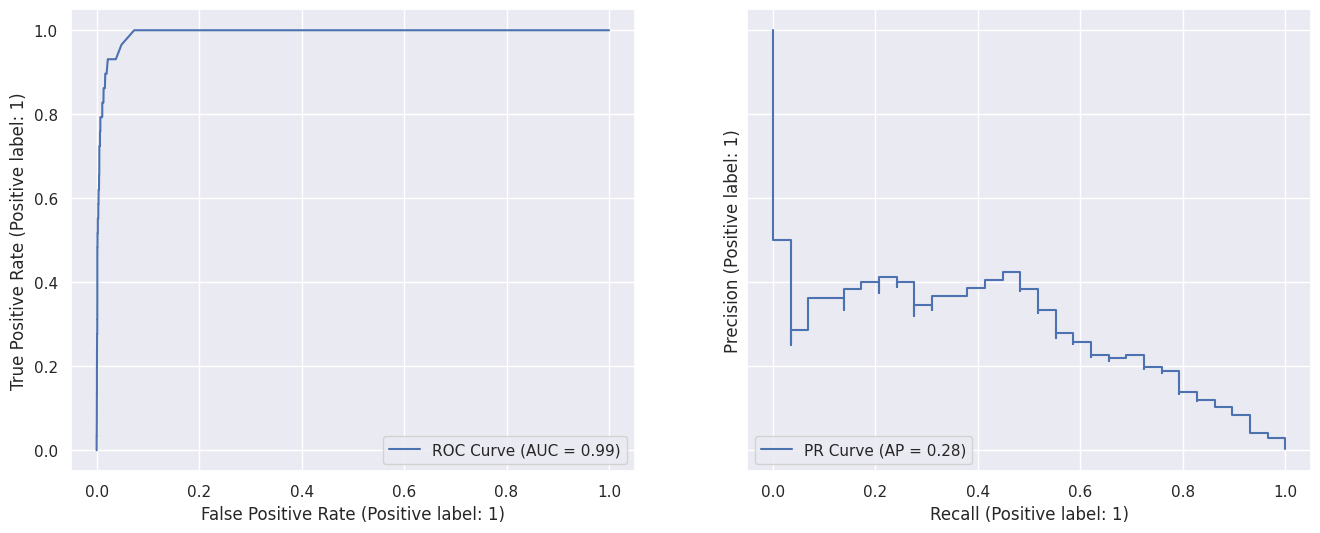

In [249]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 6))

RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=axes[0], name='ROC Curve')
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, ax=axes[1], name='PR Curve')
plt.show()

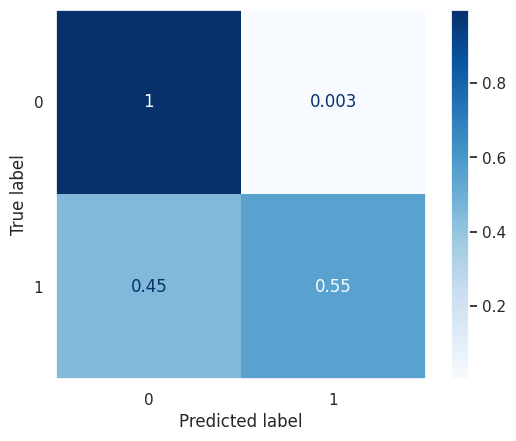

In [250]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    normalize="true"
)
plt.grid(None)
plt.show()

Предполагаем, что ложные срабатывания нам не так неприятны, как пропуск диска, у которого произойдет сбой

Тогда модель можно оценивать по метрике $F_\beta$ с $\beta > 1$ (например, $\beta = 2$)

В таком случае больший вес будет отдаваться Recall

In [251]:
from sklearn.metrics import fbeta_score

y_pred = best_model.predict(X_test)

fbeta_score(y_test, y_pred, beta=2)

0.46511627906976744

С помощью кросс-валидации на тренировочном датасете оценим средний $F_\beta$ в зависимости от выбранного порога вероятности, при котором объект определяется в класс 1

In [279]:
def f_beta_for_thresholds(thresholds: np.ndarray, y_true: np.ndarray,
                          y_pred_proba: np.ndarray, beta: float = 2) -> np.ndarray:
    """
    Вычисляем F1-Score для n равноотстоящих значений порога

    Параметры:
    ----------
        thresholds (np.ndarray): значения порога вероятности, 
                                 при превышении которого объект
                                 относится к классу 1
        y_true (np.ndarray): реальные метки классов
        y_pred_proba (np.ndarray): вектор вероятностей класса 1
        beta (float): beta для метрики F_beta
    
    Возвращает:
    -----------
         (np.ndarray): F_beta для данного числа значений порога
    """
    scores = []
    for threshold in thresholds:
        y_pred = np.where(y_pred_proba > threshold, 1, 0)
        val = fbeta_score(y_true, y_pred, beta)
        scores.append(val)
    return np.array(scores)

Всего посчитаем 41 значение $F_\beta$ для значений порога от 0 до 1

In [280]:
n = 41
scores = np.empty(n)
thresholds = np.linspace(0, 1, n)

for _, val_idx in tqdm(cv.split(X_train, y_train), total=cv.get_n_splits(), desc=f"Extra Trees CV"):
    X_fold_val, y_fold_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    y_pred_proba = best_model.predict_proba(X_fold_val)
    fold_scores = f1_for_thresholds(thresholds, np.array(y_fold_val), y_pred_proba[:, 1])
    scores = np.concatenate((scores, fold_scores), axis=0)

scores = np.mean(scores.reshape((-1, n))[1:], axis=0)

Extra Trees CV: 100%|█████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


Визуализируем на графике

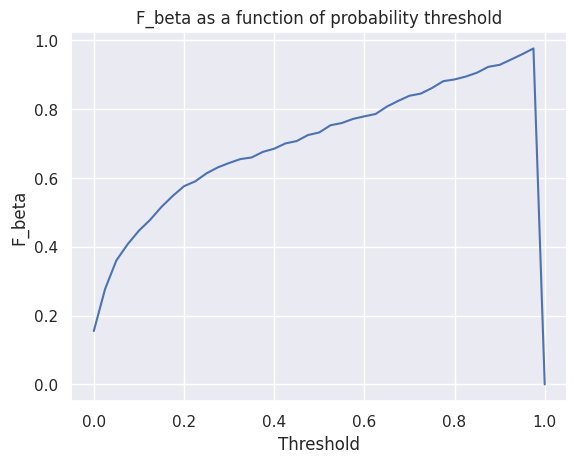

In [281]:
sns.lineplot(x=thresholds, y=scores)
plt.title('F_beta as a function of probability threshold')
plt.xlabel('Threshold')
plt.ylabel('F_beta')
plt.show()

Возрастание функции логично, т.к. большинство объектов принадлежит классу 0, а с бОльшим порогом мы всё меньше объектов определяем в позитивный класс

Тем не менее, можно попробовать взять в качестве порога значение 0.65 (вместо 0.5) и оценить результаты, не переобучая модель (нужна sklearn==1.6.0)
```python
from sklearn.frozen import FrozenEstimator
from sklearn.model_selection import FixedThresholdClassifier

model_fixed_threshold = FixedThresholdClassifier(
    estimator=FrozenEstimator(best_model),
    threshold=0.65
)
```

### SHAP

Посмотрим на важность признаков для этой модели с помощью shap

100%|===================| 27105/27126 [17:37<00:00]        

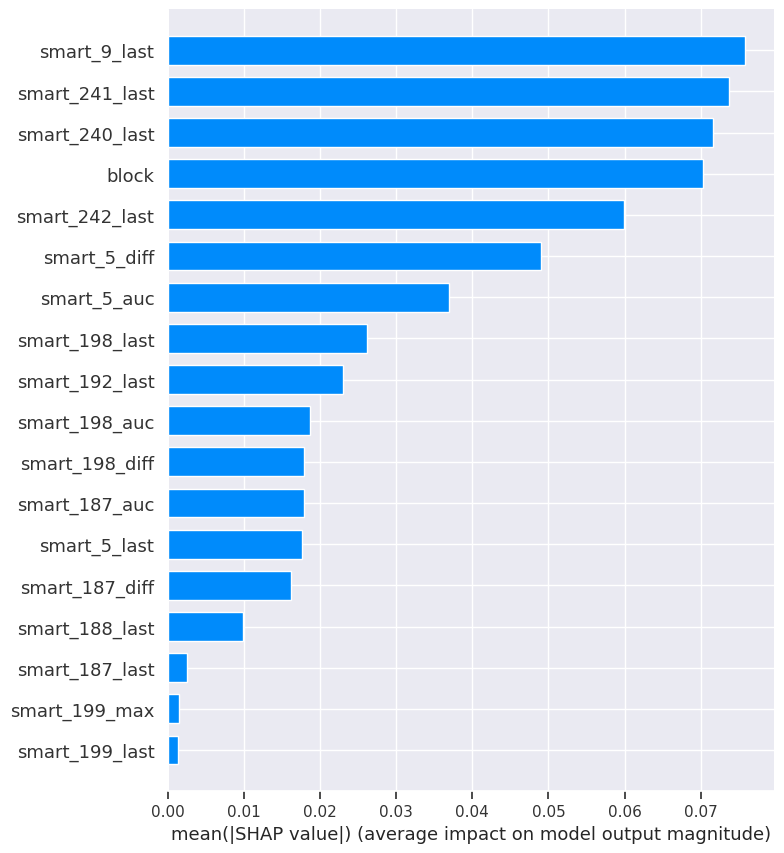

In [85]:
import shap

explainer = shap.Explainer(best_model, X_resampled)
shap_values = explainer(X_test)

# Визуализация SHAP для модели
if len(shap_values.shape) == 3:  
    shap_values_class_1 = shap_values[..., 1]  
else:
    shap_values_class_1 = shap_values 

shap.summary_plot(shap_values_class_1, X_test, plot_type="bar")

Интересно, что наиболее важные признаки здесь отличаются от выделенных ранее, хотя качество не сильно лучше

Попробуем теперь подобрать параметры, максимизирующие Recall на позитивном классе

## Эксперименты (менее удачные)

### Подбор параметров с оптимизацией другой метрики

Ниже пробовала оптимизировать F1 (1-й вариант) и F1 на позитивном классе (2-й вариант), чтобы учесть Precision и Recall одновременно

Они более показательны при большом дисбалансе классов

In [165]:
# # Определение моделей
# models_2 = {
#     # "Logistic Regression": LogisticRegression(random_state=random_state, max_iter=1000),
#     "Random Forest": RandomForestClassifier(random_state=random_state, n_jobs=4),
#     "Extra Trees": ExtraTreesClassifier(random_state=random_state, n_jobs=4),
#     "LightGBM": LGBMClassifier(random_state=random_state, num_threads=4, verbose=0),
#     "CatBoost": CatBoostClassifier(verbose=0, random_state=random_state),
#     "XGBoost": XGBClassifier(eval_metric='logloss', random_state=random_state, n_jobs=4, objective='binary:logistic')
# }

# # Определение кросс-валидации
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

In [166]:
# from sklearn.metrics import make_scorer

# def f1_positive(y_true: np.ndarray, y_pred: np.ndarray) -> float:
#     """
#     Считаем F1-score на объектах позитивного класса

#     Параметры:
#     ----------
#         y_true (np.ndarray): реальные метки классов
#         y_pred (np.ndarray): спрогнозированные метки
    
#     Возвращает:
#     -----------
#         f1_pos (float): F1-score для позитивного класса
#     """
#     y_true_pos = y_true[y_true == 1]
#     y_pred_pos = y_pred[y_true == 1]
#     f1_pos = f1_score(y_true_pos, y_pred_pos)
#     return f1_pos

# f1_pos = make_scorer(f1_positive)

In [167]:
# # Метрики, по которым будем оценивать модели
# score = {
#     'ROC-AUC': 'roc_auc', 
#     'Recall': 'recall',
#     'Precision': 'precision',
#     'F1-Score': 'f1',
#     'F1-Score Positive': f1_pos
# }

In [168]:
# best_params_dict_2 = dict()

In [169]:
# # Обучение для каждой модели
# for model_name, model in models_2.items():
#     print(f"\nОбучение модели: {model_name}")
    
#     # Использую специальный класс Pipeline из imblearn
#     # Он применяет преобразования только к тренировочному датасету
#     pipe = Pipeline([
#         ('transform', SMOTEENN(random_state=random_state)),
#         ('classify', model)
#     ])
    
#     # Всего 10 комбинаций параметров будет проверено
#     rscv = RandomizedSearchCV(
#         pipe,
#         params_dict[model_name],
#         n_iter=10,
#         cv=cv,
#         scoring=score,
#         n_jobs=4,
#         refit='F1-Score',
#         return_train_score=True
#     )
    
#     rscv.fit(X_train[final_features], y_train)

#     best_params = {key[10:]: value for key, value in rscv.best_params_.items()}
#     best_params['random_state'] = random_state
#     best_params_dict_2[model_name] = dict()
#     best_params_dict_2[model_name]['best_params'] = best_params

In [170]:
# best_params_dict_2

### Обучение с помощью балансировки весов классов (class_weight)

In [87]:
# # Определение моделей
# models_weight = {
#     # "Logistic Regression": LogisticRegression(random_state=random_state, max_iter=1000, class_weight="balanced"),
#     "Random Forest": RandomForestClassifier(random_state=random_state, class_weight="balanced"),
#     "Extra Trees": ExtraTreesClassifier(random_state=random_state, class_weight="balanced"),
#     "LightGBM": LGBMClassifier(random_state=random_state, class_weight="balanced"),
#     "CatBoost": CatBoostClassifier(verbose=0, random_state=random_state, auto_class_weights="Balanced"),
#     "XGBoost": XGBClassifier(
#         eval_metric="logloss",
#         random_state=random_state,
#         scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
#     ),
# }

# # Определение кросс-валидации
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# # Массив для хранения результатов метрик по каждой моделей
# results_weight = []

# # Обучение для каждой модели
# for model_name, model in models_weight.items():
#     print(f"\nОбучение модели: {model_name}")
#     roc_auc_scores = []
#     precision_scores = []
#     recall_scores = []
#     f1_scores = []

#     # Кросс-валидация
#     for train_idx, val_idx in tqdm(cv.split(X_train, y_train), total=cv.get_n_splits(), desc=f"{model_name} CV"):
#         X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#         y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

#         # Обучение на реальных данных
#         model.fit(X_fold_train, y_fold_train)

#         # Оценка на валидационной выборке (реальные данные)
#         y_val_pred = model.predict(X_fold_val)
#         y_val_pred_proba = model.predict_proba(X_fold_val)[:, 1]

#         roc_auc = roc_auc_score(y_fold_val, y_val_pred_proba)
#         precision = precision_score(y_fold_val, y_val_pred)
#         recall = recall_score(y_fold_val, y_val_pred)
#         f1 = f1_score(y_fold_val, y_val_pred)

#         roc_auc_scores.append(roc_auc)
#         precision_scores.append(precision)
#         recall_scores.append(recall)
#         f1_scores.append(f1)

#     # Сохранение средних значений метрик
#     results.append({
#         "Model": model_name,
#         "ROC-AUC (CV)": f"{np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}",
#         "Precision (CV)": f"{np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}",
#         "Recall (CV)": f"{np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}",
#         "F1-Score (CV)": f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}",
#     })

#     # Финальное тестирование на реальных данных
#     model.fit(X_train, y_train)
#     y_test_pred = model.predict(X_test)
#     y_test_pred_proba = model.predict_proba(X_test)[:, 1]

#     test_metrics = {
#         "ROC-AUC (Test)": roc_auc_score(y_test, y_test_pred_proba),
#         "Precision (Test)": precision_score(y_test, y_test_pred),
#         "Recall (Test)": recall_score(y_test, y_test_pred),
#         "F1-Score (Test)": f1_score(y_test, y_test_pred),
#     }

#     # Добавление тестовых метрик в финальные результаты
#     results_weight[-1].update({key: f"{value:.4f}" for key, value in test_metrics.items()})

# # Вывод таблицы результатов
# results_df = pd.DataFrame(results_weight)

# print("\nРезультаты моделей:")
# results_df

In [88]:
# results_df.to_csv("results/models_results_weighted.csv", index=False)

## Выводим результаты

In [90]:
with open('results/models_results_resampled.csv') as f:
    res = pd.read_csv(f)

res

,Model,ROC-AUC (CV),Precision (CV),Recall (CV),F1-Score (CV),ROC-AUC (Test),Precision (Test),Recall (Test),F1-Score (Test)
0,Random Forest,0.9605 ± 0.0324,0.0592 ± 0.0082,0.7635 ± 0.1111,0.1099 ± 0.0153,0.9379,0.0545,0.7241,0.1014
1,Extra Trees,0.9643 ± 0.0199,0.2293 ± 0.0538,0.4611 ± 0.1273,0.3057 ± 0.0749,0.9925,0.2857,0.5517,0.3765
2,LightGBM,0.9301 ± 0.0237,0.1914 ± 0.0550,0.4026 ± 0.1258,0.2583 ± 0.0734,0.9615,0.2500,0.5172,0.3371
3,XGBoost,0.8667 ± 0.0438,0.1585 ± 0.0385,0.4386 ± 0.1237,0.2320 ± 0.0570,0.9467,0.2206,0.5172,0.3093
4,CatBoost,0.8494 ± 0.0683,0.1078 ± 0.0209,0.5397 ± 0.1176,0.1793 ± 0.0341,0.9489,0.1417,0.6207,0.2308
